# Size density analysis

In the preliminary analysis, we found that some factors had a much higher impact on the performances than others. For instance, compiling with GCC optimizations has a great impact.

We will now study the performances of roaring bitmap for various sizes and densities.

The command used to get the results is given later. This is a Python script that runs the experiments with the given parameters and outputs the results in the given CSV file.

It can takes the options `--amalg`, `--gcc`, `--avx`, `--cow` and `--run` which respectively enable amalgamation, GCC optimization, AVX optimization, copy on write and run containers optimization. Each of these options also come with its opposite (for an option `--foo`, there is an option `--no-foo`).

The size of the roaring bitmaps are given by the arguments `--size1` and `--size2`, their densities by the arguments `--density1` and `--density2`. Sizes are integers, densities are floats.
These arguments can be a single value (e.g. `--size1 27`), a list of values (e.g. `--size1 32,64,128,256`) or a range of values (e.g. `--size1 1:1000`).
The value actually used for each experiment is sampled randomly and uniformly in the given list (resp. range).

The argument `--size2` (resp. `--density2`) can be omitted. In this case, the random value used for each experiment will be exactly the same than the one used for the first size (resp. the first density). In this case, the two sizes (resp. densities) are therefore not independent anymore.

In [1]:
library(ggplot2)

We will now consider the impact of density.

The following results have been obtained with the command:
```bash
./scripts/size_density_runner.py --amalg --gcc --avx --no-cow --run\
    --size1 1:40000000 --size2 1:40000000\
    --density1 0.01,0.04,0.1,0.5,0.999\
    -n 600 results.csv # long, about a whole night...
```

Size of the two roaring bitmaps are sampled randomly and uniformly in [0, 4*10^7], a density is sampled randomly and uniformly in {0.01, 0.04, 0.1, 0.5, 0.999} (same density for the two bitmaps), all optimizations are enabled except copy on write.

In [2]:
all_times_broadwell = read.csv("results/broadwell_size_density_results.csv")
all_times_broadwell$density1 <- factor(all_times_broadwell$density1)
all_times_broadwell$size_sum <- apply(all_times_broadwell[,c('size1','size2')], 1, function(y) sum(y['size1'],y['size2'])) # can also take the max

all_times_skylake = read.csv("results/skylake_size_density_results.csv")
all_times_skylake$density1 <- factor(all_times_skylake$density1)
all_times_skylake$size_sum <- apply(all_times_skylake[,c('size1','size2')], 1, function(y) sum(y['size1'],y['size2'])) # can also take the max

## Broadwell

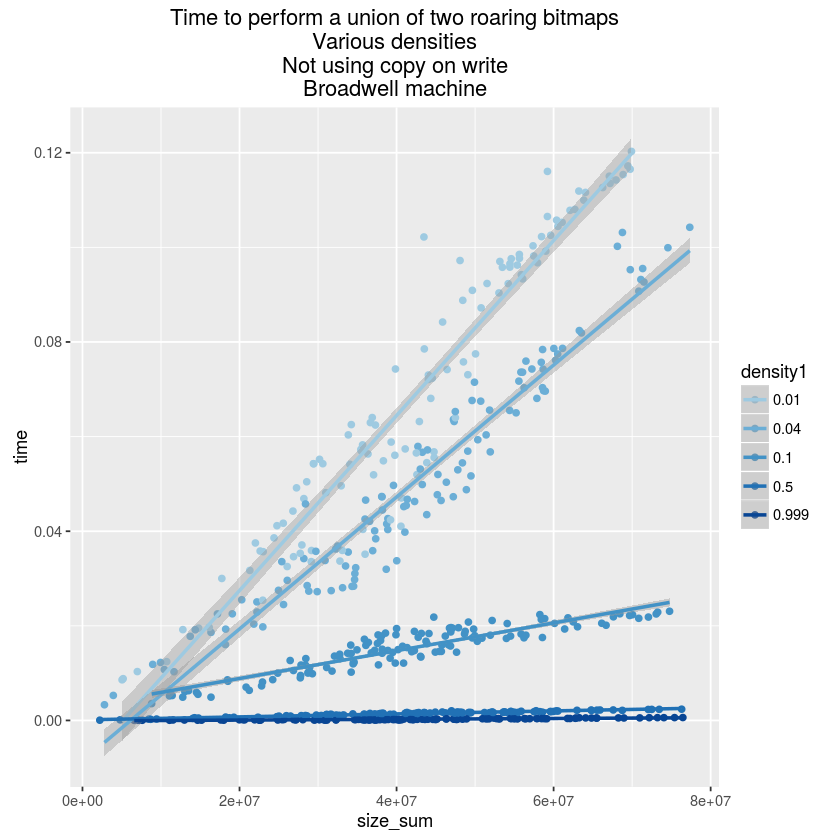

In [3]:
library(RColorBrewer)
my_colors = brewer.pal(n = 7, "Blues")[3:7] # we exclude the lightest colors

ggplot(all_times_broadwell, aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            ggtitle("Time to perform a union of two roaring bitmaps\nVarious densities\nNot using copy on write\nBroadwell machine") +
            scale_colour_manual(values=my_colors)
            #scale_color_brewer(type="seq") # alternative, without excluding colors

For clarity, we plot the same graph in log scale.

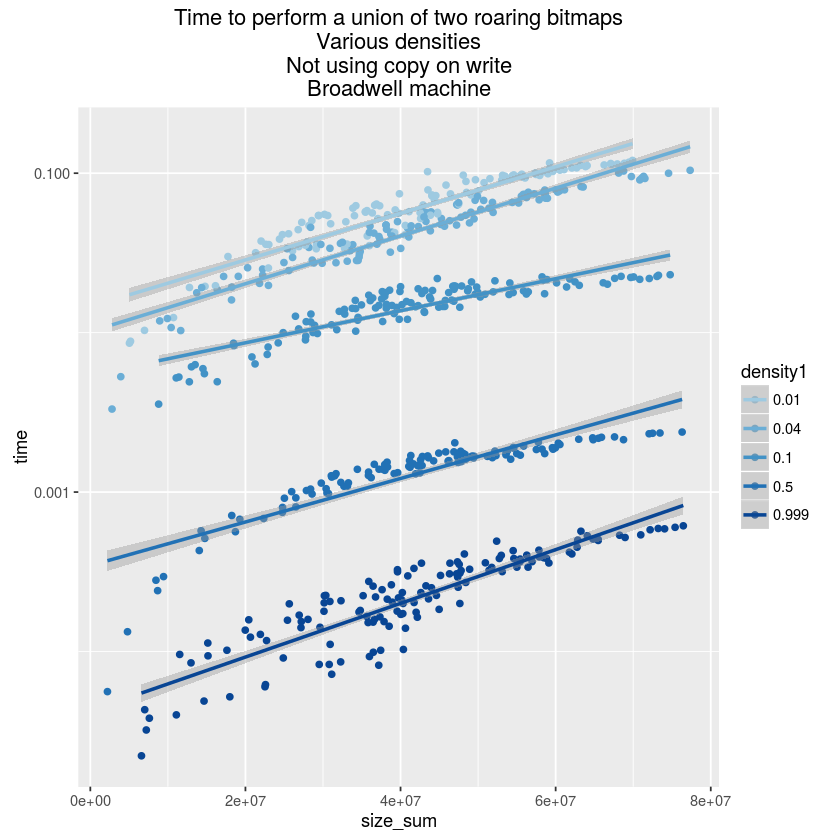

In [4]:
ggplot(all_times_broadwell, aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            ggtitle("Time to perform a union of two roaring bitmaps\nVarious densities\nNot using copy on write\nBroadwell machine") +
            scale_colour_manual(values=my_colors) +
            scale_y_log10()

## Skylake

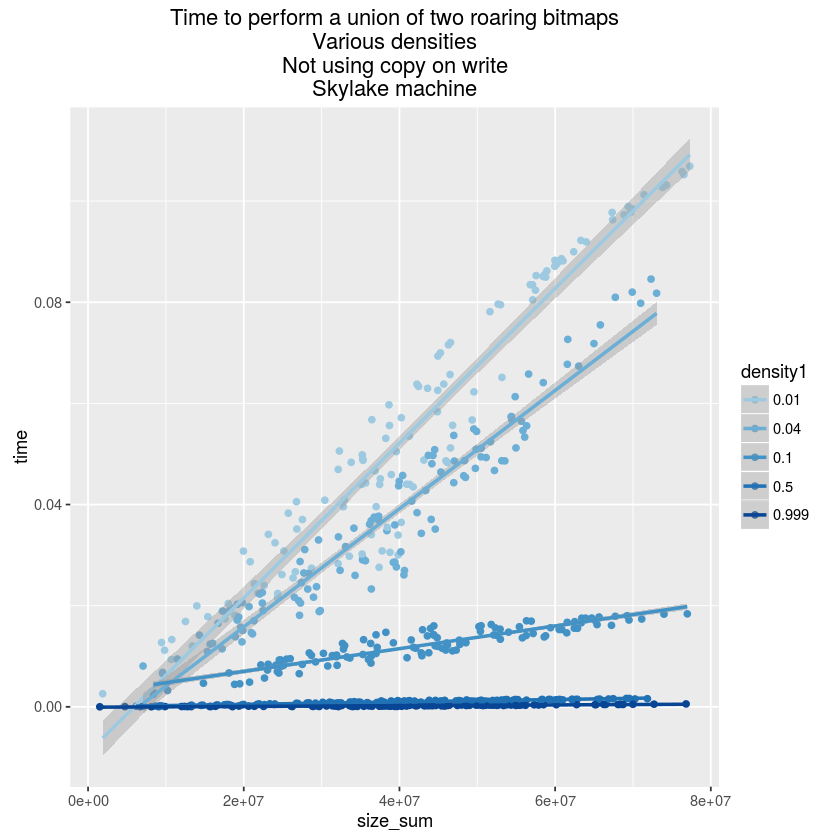

In [5]:
ggplot(all_times_skylake, aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            ggtitle("Time to perform a union of two roaring bitmaps\nVarious densities\nNot using copy on write\nSkylake machine") +
            scale_colour_manual(values=my_colors)

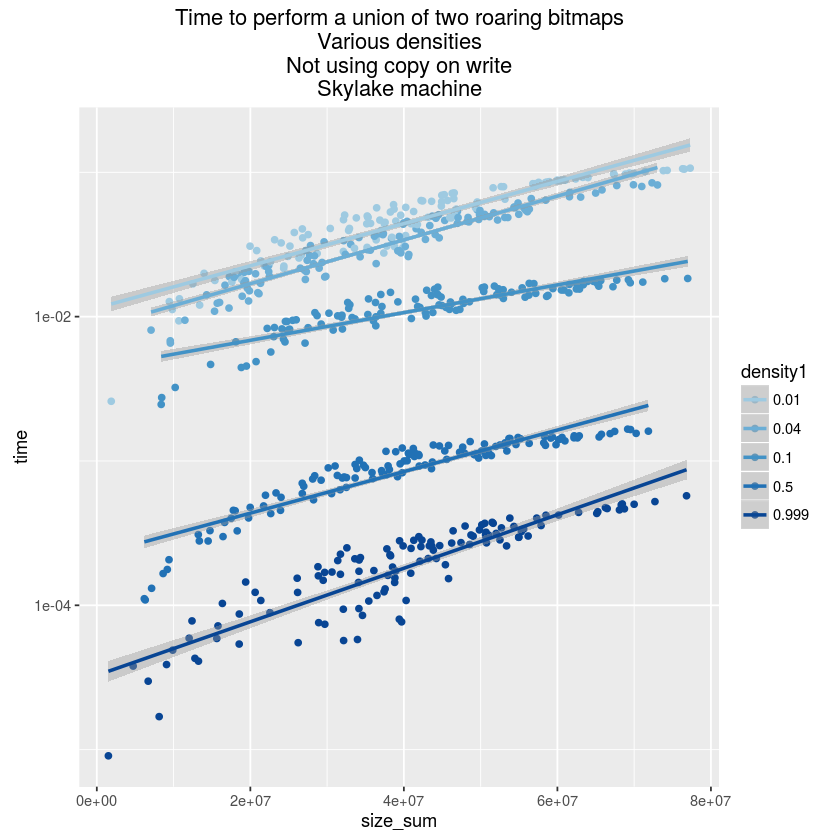

In [6]:
ggplot(all_times_skylake, aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            ggtitle("Time to perform a union of two roaring bitmaps\nVarious densities\nNot using copy on write\nSkylake machine") +
            scale_colour_manual(values=my_colors) +
            scale_y_log10()

## Conclusion

In [7]:
for(density in sort(unique(all_times_broadwell[,'density1']))) {
    print(paste('density =', density))
    print(lm(time~size_sum, data=all_times_broadwell[all_times_broadwell['density1'] == density,])$coefficients)
}

[1] "density = 0.01"
  (Intercept)      size_sum 
-9.539846e-03  1.849888e-09 
[1] "density = 0.04"
  (Intercept)      size_sum 
-8.550684e-03  1.394541e-09 
[1] "density = 0.1"
 (Intercept)     size_sum 
2.997011e-03 2.936602e-10 
[1] "density = 0.5"
 (Intercept)     size_sum 
1.206255e-04 3.157753e-11 
[1] "density = 0.999"
  (Intercept)      size_sum 
-9.446456e-05  8.517305e-12 


In [8]:
for(density in sort(unique(all_times_skylake[,'density1']))) {
    print(paste('density =', density))
    print(lm(time~size_sum, data=all_times_skylake[all_times_skylake['density1'] == density,])$coefficients)
}

[1] "density = 0.01"
  (Intercept)      size_sum 
-9.063958e-03  1.529859e-09 
[1] "density = 0.04"
  (Intercept)      size_sum 
-7.590536e-03  1.169079e-09 
[1] "density = 0.1"
 (Intercept)     size_sum 
2.517932e-03 2.245492e-10 
[1] "density = 0.5"
 (Intercept)     size_sum 
5.896631e-06 2.395091e-11 
[1] "density = 0.999"
  (Intercept)      size_sum 
-7.515007e-05  7.562317e-12 


We see here that the densities of the two roaring bitmaps change a lot the performances. Low densities like 0.01 or 0.04 yield to a union two orders of magnitude slower than high densities like 0.5 or 0.999.

We recall that the transition from array container to bitset container happens when the container holds 2^12 elements. The maximum number of elements is 2^16, so this corresponds to a density of 2^-4 = 0.0625. Therefore, in our experiments, the two lowest densities are more likely to have array (and maybe run) containers whereas the other densities are more likely to have bitset (and maybe run) containers.

Also, bitmaps with lower densities will have a larger number of containers, with less elements per containers.

We also see that we get slightly better performances with the Skylake machine than with the Broadwell machine (speedup between 1.07 and 1.34, depending on the density).

The overall performances are very good: 0.01ns to 1ns per element.